# ResNet Feature Map Extraction and Classification Mapping

This notebook demonstrates a complete workflow for extracting ResNet feature maps and mapping per-feature classifications back to the input image resolution:

1. **Extract feature maps** from a pretrained ResNet model (configurable: 18, 34, 50, 101, 152)
2. **Classify each feature** map position (placeholder for SVM or other classifier)
3. **Map classifications** to input resolution using disjoint, non-overlapping tiles
4. **Visualize** the upscaled segmentation masks

## 1. Import Required Libraries

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 2. Configure ResNet Feature Extractor

Define a custom feature extractor class that extracts intermediate feature maps from any ResNet architecture (18, 34, 50, 101, or 152).

In [4]:
# ============ CONFIGURATION: Choose ResNet version ============
RESNET_VERSION = 50  # Options: 18, 34, 50, 101, 152
# ===============================================================

class ResNetFeatureExtractor(nn.Module):
    _resnet_models = {
        18: models.resnet18,
        34: models.resnet34,
        50: models.resnet50,
        101: models.resnet101,
        152: models.resnet152,
    }

    _weights_map = {
        18: models.ResNet18_Weights.IMAGENET1K_V1,
        34: models.ResNet34_Weights.IMAGENET1K_V1,
        50: models.ResNet50_Weights.IMAGENET1K_V1,
        101: models.ResNet101_Weights.IMAGENET1K_V1,
        152: models.ResNet152_Weights.IMAGENET1K_V1,
    }
    def __init__(self, resnet_version: int = 18, pretrained: bool = True):
        super().__init__()
        

        if resnet_version not in ResNetFeatureExtractor._resnet_models:
            raise ValueError(f"Invalid ResNet version. Choose from: {list(ResNetFeatureExtractor._resnet_models.keys())}")
        
        
        weights = ResNetFeatureExtractor._weights_map[resnet_version] if pretrained else None
        self.resnet = ResNetFeatureExtractor._resnet_models[resnet_version](weights=weights)
        self.resnet.eval()


    def forward(self, x: torch.Tensor) -> dict[str, torch.Tensor]:
        feature_maps = OrderedDict()

        x = self.resnet.conv1(x)
        feature_maps['conv1'] = x
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        feature_maps['layer1'] = x
        x = self.resnet.layer2(x)
        feature_maps['layer2'] = x
        x = self.resnet.layer3(x)
        feature_maps['layer3'] = x
        x = self.resnet.layer4(x)
        feature_maps['layer4'] = x
        return feature_maps



## 3. Load and Preprocess Input Image

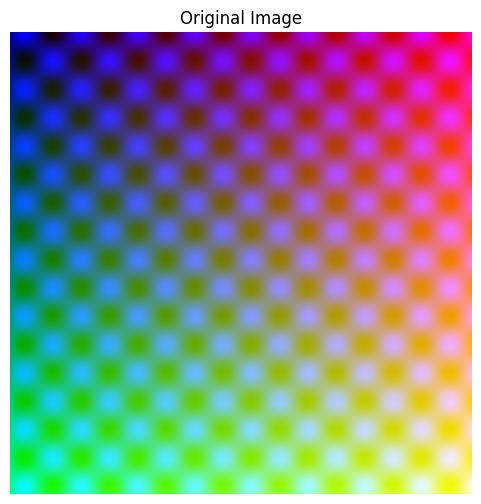

Input tensor shape: torch.Size([1, 3, 512, 512])


In [ ]:
# Create a sample image or load your own
# For demo purposes, create a synthetic image
def create_sample_image(size=(512, 512)):
    """Create a simple sample image for demonstration"""
    img = Image.new('RGB', size, color='white')
    # Add some patterns
    pixels = img.load()
    for i in range(size[0]):
        for j in range(size[1]):
            r = int(255 * i / size[0])
            g = int(255 * j / size[1])
            b = int(128 + 127 * np.sin(i/10) * np.cos(j/10))
            pixels[i, j] = (r, g, b)
    return img

# Create or load image
# To use your own image, uncomment and modify:
# image = Image.open('path/to/your/image.jpg')
image = create_sample_image()

# Display original image
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Define preprocessing transformations (ImageNet standard)
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Preprocess the image
input_tensor = preprocess(image).unsqueeze(0).to(device)
print(f"Input tensor shape: {input_tensor.shape}")

## 4. Extract Feature Maps

Run the input image through the feature extractor to obtain feature maps at different depths (conv1, layer1-4).

In [7]:
feature_extractor = ResNetFeatureExtractor(resnet_version=RESNET_VERSION, pretrained=True).to(device)
feature_maps = feature_extractor.forward(input_tensor)
feature_maps.size()

AttributeError: 'collections.OrderedDict' object has no attribute 'size'

## 5. Classify Feature Maps (Placeholder)

This placeholder function simulates a per-pixel classifier (e.g., SVM). Replace with your actual classification logic.
Each feature map position gets assigned a class label.

In [45]:
def classify(map: torch.Tensor):
    h, w = map.shape[-2], map.shape[-1]

    # Example classification logic (to be replaced with actual SVM classifier)
    cls = (torch.arange(h * w) % 20).reshape(h, w)
    cls = cls.to(map.device)

    return cls.float()

classification = {
    layer: classify(feature_maps[layer]) for layer in feature_maps
}

## 6. Map Classifications to Input Resolution

Use `F.interpolate` with `mode='nearest'` to upscale feature map classifications to the input image size.

This creates **disjoint, non-overlapping tiles** where each input pixel belongs to exactly one feature map position.- Perfect for segmentation masks where regions must not overlap

- Each feature maps to a stride×stride pixel block in the input

**Why nearest neighbor?**- Preserves discrete class labels (no interpolation/blending)

Classification for layer conv1: torch.Size([256, 256])
Classification for layer layer1: torch.Size([128, 128])
Classification for layer layer2: torch.Size([64, 64])
Classification for layer layer3: torch.Size([32, 32])
Classification for layer layer4: torch.Size([16, 16])


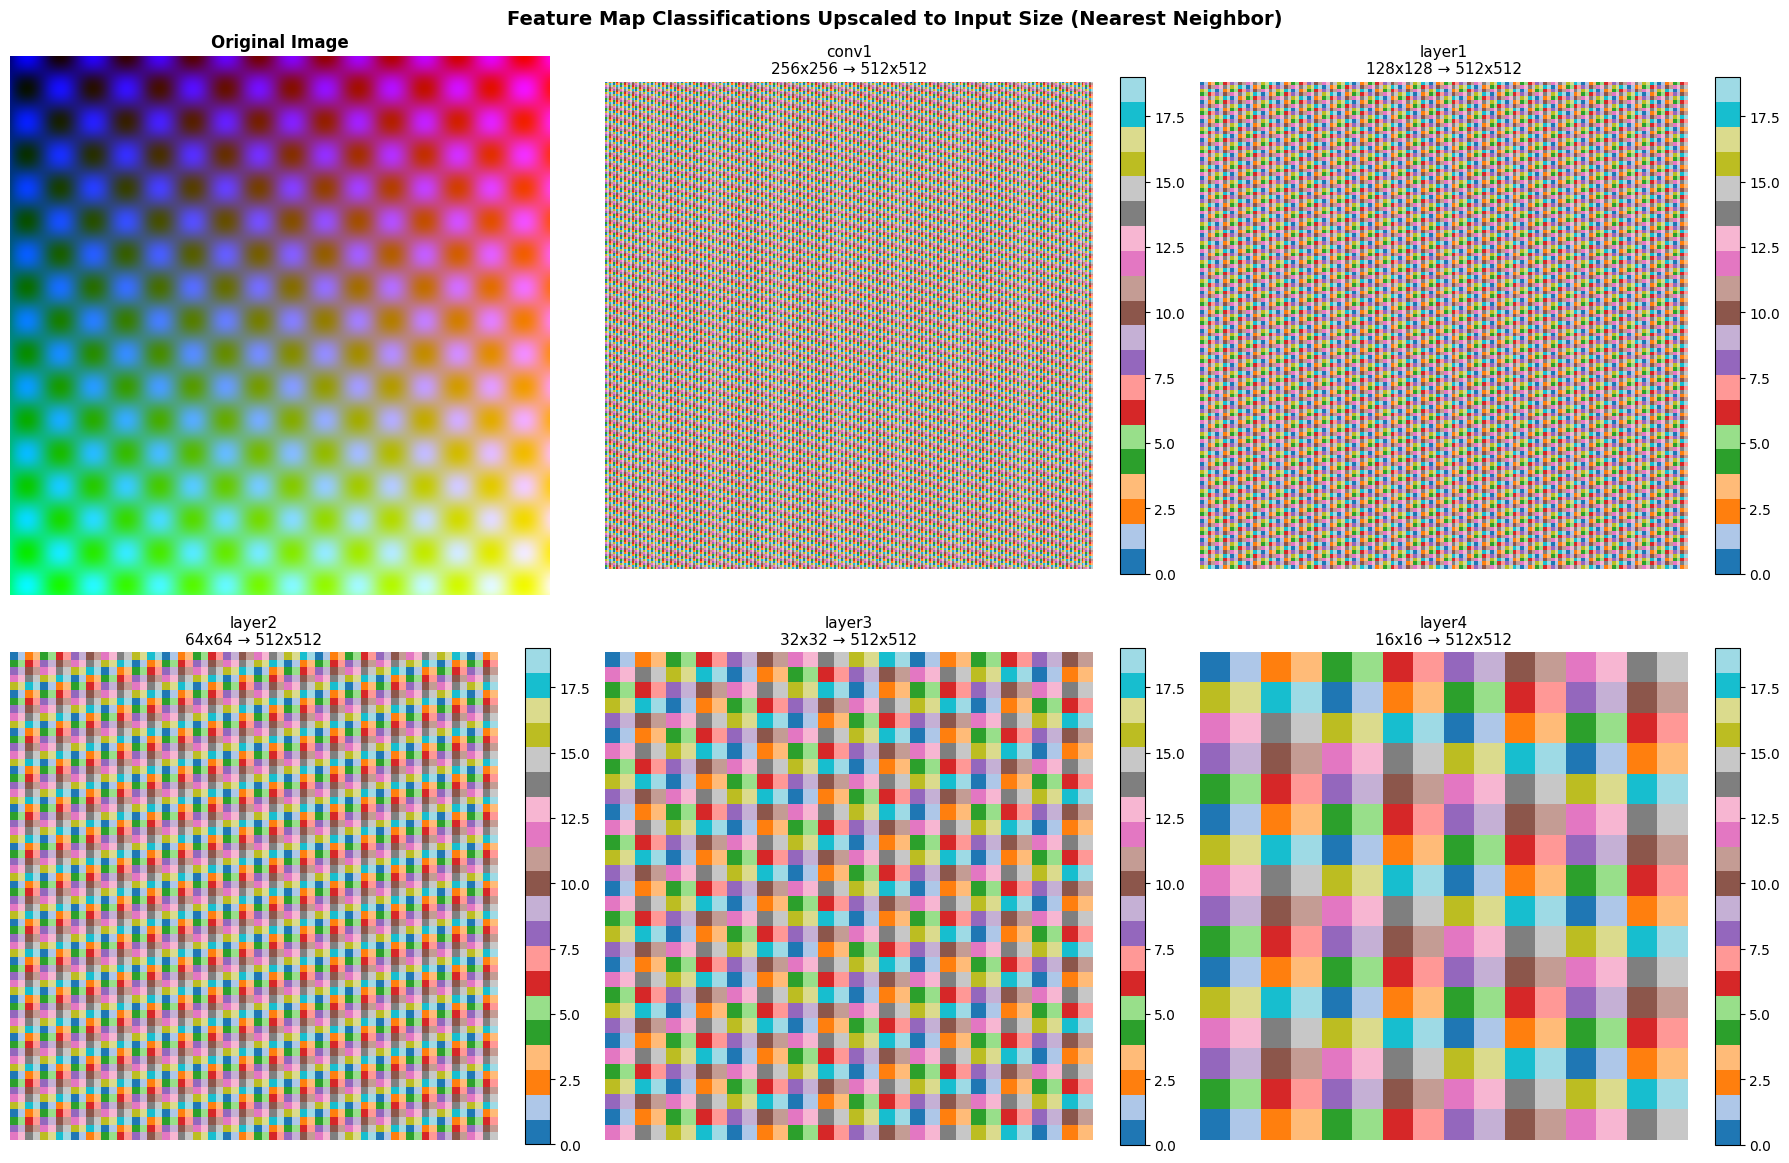

In [47]:
input_height, input_width = input_tensor.shape[2], input_tensor.shape[3]

# Store upscaled classifications for all layers
upscaled_classifications = {}

for layer, cls in classification.items():
    print(f"Classification for layer {layer}: {cls.shape}")
    upscaled_cls = F.interpolate(
        cls[None, None, :, :],  # interpolate expects tensor of shape (bs, n_channels, h, w)
        size=(input_height, input_width),
        mode='nearest'
    )[0, 0, :, :]
    upscaled_classifications[layer] = upscaled_cls

# Visualize original image and upscaled classifications
num_layers = len(upscaled_classifications)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Original image (denormalize for display)
original_img = input_tensor[0].cpu()
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
denorm_img = original_img * std + mean
denorm_img = torch.clamp(denorm_img, 0, 1).permute(1, 2, 0).numpy()

axes[0].imshow(denorm_img)
axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Plot each layer's upscaled classification
for idx, (layer, upscaled_cls) in enumerate(upscaled_classifications.items(), start=1):
    cls_np = upscaled_cls.cpu().numpy()
    
    im = axes[idx].imshow(cls_np, cmap='tab20', interpolation='nearest')
    axes[idx].set_title(f'{layer}\n{classification[layer].shape[0]}x{classification[layer].shape[1]} → '
                       f'{upscaled_cls.shape[0]}x{upscaled_cls.shape[1]}', 
                       fontsize=11)
    axes[idx].axis('off')
    plt.colorbar(im, ax=axes[idx], fraction=0.046)

plt.suptitle('Feature Map Classifications Upscaled to Input Size (Nearest Neighbor)', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()